In [100]:
import numpy as np
import pandas as pd

# pour afficher toutes les colonnes:
pd.options.display.max_columns = None

import matplotlib.pyplot as plt# Pie chart
import matplotlib.cm as cm

#nlp
from sklearn.feature_extraction.text import CountVectorizer

# modélisation
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# évaluation modèle
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [107]:
df_model = pd.read_csv("../dataset/data_modelisation.csv", sep=',')
#df_model = df_model.drop(['Unnamed: 0'], axis=1)
df_model.head()

df = pd.read_csv("../dataset/data_gp.csv", sep=',')
#df = df.drop(['Unnamed: 0'], axis=1)
df.head()
#df_model.head()

,Unnamed: 0,date,nos,ind,jour,semaine,mois,menu,gaspillage_volume,ferie,vacances,prevision,reel,site_nom,site_type,annee_scolaire,effectif,Longitude_Latitude
0,0,2011-01-03,1.0,0,Lundi,1,Janvier,"['Pamplemousse', 'Hachis Parmentier', 'Salade ...",1160,0,0,131.0,122.0,CHENE D'ARON,E,2010-2011,145.0,"[-1.56090982193118,47.2122056379041]"
1,1,2011-01-03,1.0,0,Lundi,1,Janvier,"['Pamplemousse', 'Hachis Parmentier', 'Salade ...",1160,0,0,73.0,58.0,CHENE D'ARON,M,2010-2011,78.0,"[-1.56031985366696,47.2120061437076]"
2,2,2011-01-03,1.0,0,Lundi,1,Janvier,"['Pamplemousse', 'Hachis Parmentier', 'Salade ...",1160,0,0,49.0,49.0,COTE D'OR,M,2010-2011,66.0,"[-1.57259938808227,47.2472636471014]"
3,3,2011-01-03,1.0,0,Lundi,1,Janvier,"['Pamplemousse', 'Hachis Parmentier', 'Salade ...",1160,0,0,265.0,241.0,AGENETS,M/E,2010-2011,295.0,"[-1.53043977895119,47.2276390419726]"
4,4,2011-01-03,1.0,0,Lundi,1,Janvier,"['Pamplemousse', 'Hachis Parmentier', 'Salade ...",1160,0,0,57.0,53.0,ALAIN FOURNIER,M,2010-2011,114.0,"[-1.60177038499681,47.2041450203042]"


## Construction des datasets

In [108]:
df_model['date'] = pd.to_datetime(df_model['date'])
df_model.set_index('date', inplace=True)

train_data = df_model['2015-09':'2018-07']
X_train = train_data[['effectif','porc','viande','poisson','bio','noel','an_chinois','plat_prepare','maison','laitage']]
y_train = train_data[['reel']]

test_data = df_model['2018-09':'2019-07']
X_test = test_data[['effectif','porc','viande','poisson','bio','noel','an_chinois','plat_prepare','maison','laitage']]
y_test = test_data[['reel']]

data = df_model.drop(['effectif'], axis=1)
X = data['2015-09':'2020-07']
y = X[['reel']]

In [109]:
# baseline
### RMSE de référence pour les prévisions, elles doivent être en dessous de ce 
### score pour que le modèle soit considéré commec correct

avg_fare = round(np.mean(y_train), 2)
baseline_pred = np.repeat(avg_fare, y_test.shape[0])
baseline_MSE = (mean_squared_error(baseline_pred, y_test))
baseline_RMSE = baseline_MSE **0.5
print("RMSE de référence sur les données de validation :", baseline_RMSE)

RMSE de référence sur les données de validation : 1367.5703283756325


In [111]:
df_model = df_model.drop(['effectif'], axis=1)
X = df_model['2015-09':'2020-07']
y = X[['reel']]

In [112]:
#On commence à entrainer le modèle à partir de l'année scolaire 2015-2016
#On test sur l'année 2018-2019


X_train = X['2015-09':'2018-07']  # 3 années scolaires pour entraînement
y_train = y['2015-09':'2018-07']

# Période de test (2018-2019)
X_test = X['2019-09':'2020-07']  
y_test = y['2019-09':'2020-07']

# construction du modèle de régression linéaire multiple de moindre carré ordinaire
mod = sm.OLS(y_train, X_train)

# lancement de l'entraînement
res = mod.fit()


print(res.summary())

#dfm = df_model

# prédiction du modèle
y_pred = res.predict(X_test)
y_true = y_test

                                 OLS Regression Results                                
Dep. Variable:                   reel   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.745e+32
Date:                Wed, 25 Sep 2024   Prob (F-statistic):                        0.00
Time:                        00:09:59   Log-Likelihood:                          9414.1
No. Observations:                 383   AIC:                                 -1.881e+04
Df Residuals:                     373   BIC:                                 -1.877e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

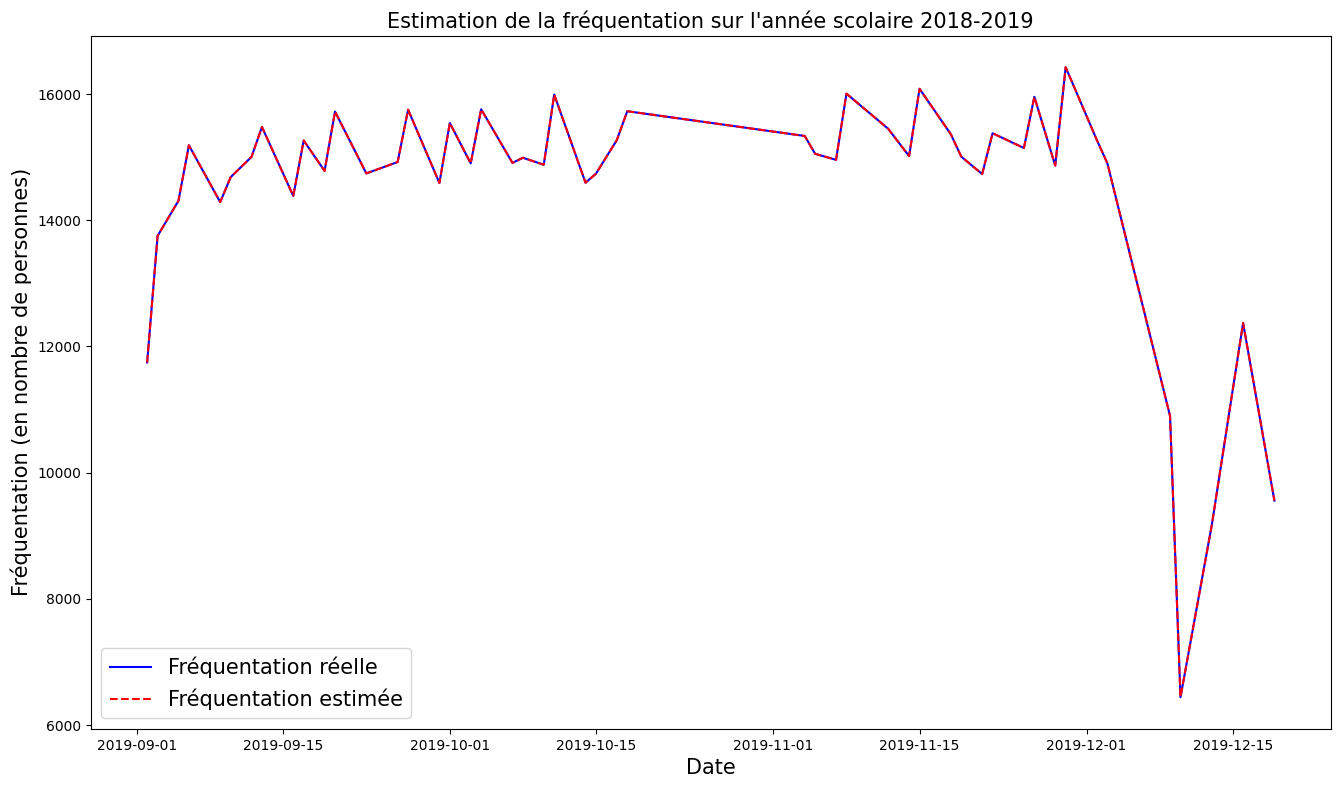

In [116]:
# Visualisation
plt.figure(figsize=(16,9))
plt.plot(y_true.index, y_true, label="Fréquentation réelle", color='blue')
plt.plot(y_pred.index, y_pred, label="Fréquentation estimée", color='red', linestyle='--')

plt.title("Estimation de la fréquentation sur l'année scolaire 2018-2019", fontsize=15)
plt.ylabel("Fréquentation (en nombre de personnes)", fontsize=15)
plt.xlabel("Date", fontsize=15)

plt.legend(fontsize=15)

In [20]:
# Préparation des données pour afficher la comparaison entre les valeurs prédites et estimées
X_pred = X.iloc[N_INT:N_END].join(df[["prevision",  "date",'nos','ind']].set_index('date').groupby("date").sum())
X_pred["pred"] = y_pred

# temp.porc[(temp['porc'] > 1)] = 1

X_pred.nos[(X_pred['nos'] > 0 )] = X_pred.reel
X_pred.ind[(X_pred['ind'] >0)] = X_pred.reel
X_pred["gaspillage"] = (X_pred["prevision"] - X_pred["reel"]) / X_pred["prevision"]
X_pred["gaspi_pred"] = (X_pred.pred - X_pred.reel) / X_pred.pred

/tmp/ipykernel_1238/241698557.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X_pred.nos[(X_pred['nos'] > 0 )] = X_pred.reel
/tmp/ipykernel_1238/241698557.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr